In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re

def minMaxScale(data, m = None): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (m != None): mini = m
    
    return (data - mini)/(maxi - mini)

In [2]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)

In [3]:
print(len(data), len(data_profit))
display(data.sample(), data_profit.sample()) #samples of our data with and without budgets

78684 49058


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
40252,Leonardo DiCaprio,M,1974-11-11,The Man in the Iron Mask,1998.0,182968902.0,132.0,6.777778,173453,"[' ""Action/Adventure""', ' ""Drama""', ' ""Action""...","[' ""United States of America""', ' ""United King...",2.690719e+08


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
14144,Fyvush Finkel,M,1922-10-09,For Love or Money,30000000,1993.0,11146270.0,96.0,6.967647,18827,"[' ""Romantic comedy""', ' ""Romance Film""', ' ""C...","[' ""United States of America""}']",-18853730.0,-3.142288e+07


In [4]:
worst_profit = min(data_profit['profit_adj']) 
#worst movie
data_profit.query(f'profit_adj == {worst_profit}').sample()

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,budget,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,profit,profit_adj
367,Frank Reicher,M,1875-12-02,King Kong,207000000,1933.0,1856000.0,100.0,7.178571,543198,"[' ""Monster movie""', ' ""Horror""', ' ""Adventure...","[' ""United States of America""}']",-205144000.0,-4.102880e+09


Here, we can see there are issues with the matching of movies & budgets. It is matching the budget for the 2005 King Kong movie to the 1933 King Kong movie, we will remove these outliers of data matching errors will for further movie success analysis.

In [5]:
#After some research seeing that the largest movie losses aren't over 100 million
movies_profit = data_profit.drop_duplicates(subset = 'Movie_name')
len(movies_profit.query(f'profit_adj <= -100000000'))
#59 movies that lost more than 100 million dollars, we can presume that these are mismatched movies in the budgets
#and there are maybe more than 59

59

In [6]:
print('actor data without the budget ', len(data.drop_duplicates(subset = 'Actor_name')), 'actor data with the budget',  
      len(data_profit.drop_duplicates(subset = 'Actor_name'))) 
print('movie data without the budget ', len(data.drop_duplicates(subset = 'Movie_name')), 'movie data with the budget',  
      len(data_profit.drop_duplicates(subset = 'Movie_name'))) 

actor data without the budget  21924 actor data with the budget 15502
movie data without the budget  7361 movie data with the budget 3610


Because of the mismatched budget data and hard drop off in data points of actors & movies we have decided to calculate for the P2 milestone the star score of our actors without taking into account the budget but we will be using it for further regression analysis.

## Observation of distributions

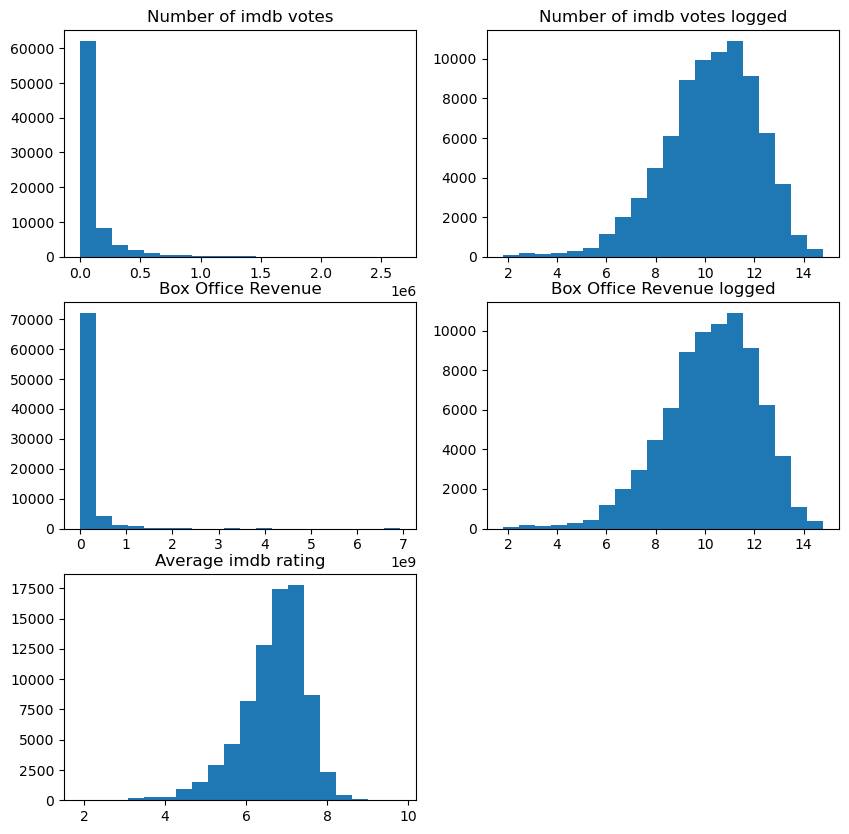

In [7]:
#observation of distributions
fig, ax = plt.subplots(3, 2, figsize=(10, 10)) #sharey=True)

titles = ['Number of imdb votes', 'Box Office Revenue']
for idx, feature in enumerate(['numVotes', 'box_office_adj']):
    ax[idx, 0].hist(data[feature], bins = 20)
    ax[idx, 0].set_title(titles[idx])
    ax[idx, 1].hist(np.log(data['numVotes']), bins = 20)
    ax[idx, 1].set_title(titles[idx] + ' logged')
    
ax[2, 0].hist(data['averageRating'], bins = 20)
ax[2, 0].set_title('Average imdb rating')
ax[2, 1].remove()

plt.show()

# Star score calculation

first we need to deflate the imdb ratings by the amount of votes they've gotten

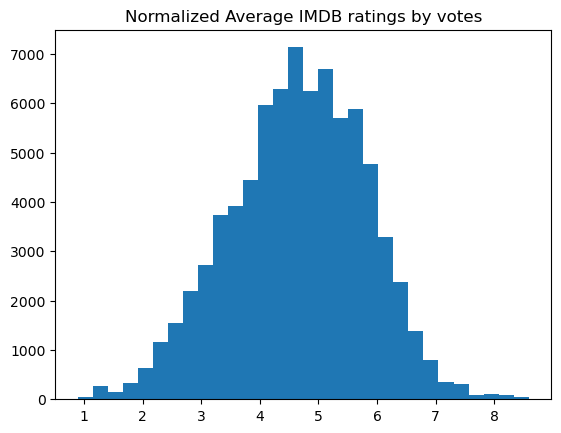

In [8]:
data['numVotes_factor'] = minMaxScale(np.log(data['numVotes']), m = 0)
data['averageRating_adj'] =  data['averageRating']* data['numVotes_factor']
plt.hist(data['averageRating_adj'], bins = 30) #adjusted to the number of votes
plt.title("Normalized Average IMDB ratings by votes")
plt.show()

## Normality tests of our logged box office & our imdb grade dataset
To see if our distributions are log)-normal and normal.

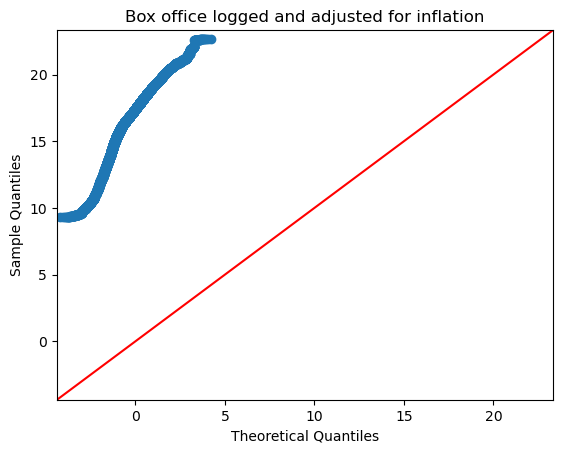

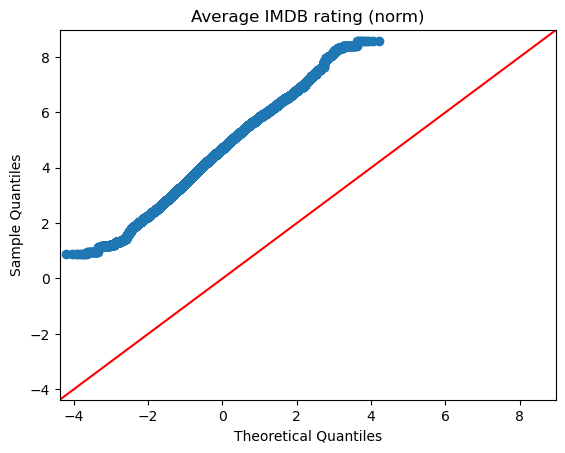

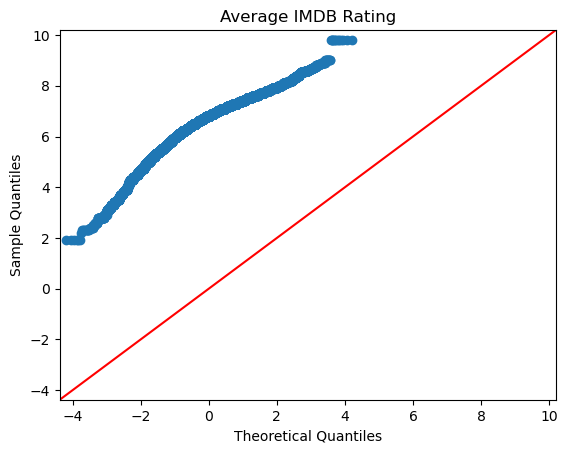

In [9]:
#QQ plots of the distributions to assess how much our logged and adjusted for votes imdb grades match a normal dist

data['box_office_adj_log'] = np.log(data['box_office_adj'])
factors = ['box_office_adj_log', 'averageRating_adj', 'averageRating']
titles = ['Box office logged and adjusted for inflation', 'Average IMDB rating (norm)', 'Average IMDB Rating']
for idx, factor in enumerate(factors): 
    sm.qqplot(data[factor], line='45')
    plt.title(titles[idx])
    
plt.show()

In [10]:
from scipy.stats import kstest #Kolmogorov–Smirnov test of normality

for factor in factors: 
    print(factor + ' normality = ', kstest(data[factor], 'norm')) 

box_office_adj_log normality =  KstestResult(statistic=1.0, pvalue=0.0)
averageRating_adj normality =  KstestResult(statistic=0.9672104945753547, pvalue=0.0)
averageRating normality =  KstestResult(statistic=0.9976979450558071, pvalue=0.0)


We can see that despite our plotted observations our box office data is not log-normal
and our average imdb grades aswell as our adjusted grades are not normally distributed (p value < 0, we can reject the null hypothesis that says they are normal).

#### Star scores to the latest date of the dataset 
This is for the P2 milestone, we will do longitudinal (temporal) star scores for P3

In [11]:
data['actor'] = data["Actor_name"].apply(lambda x : '_'.join(x.split())) #simplifying actor names
star_scores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True)) #creation of starscore dataf

In [ ]:
for idx, actor in enumerate(star_scores['actor']):
    
    ds = data[data['actor'] == actor] #dataframe of all the actor's movies
    star_scores.loc[idx, 'rev_sum'] = ds['box_office_adj'].sum() #sum of the box offices of the actor's movies 
    star_scores.loc[idx, 'grade_sum'] = ds['averageRating_adj'].sum() #sum of the adjusted grades of the movies
    star_scores.loc[idx, 'appearances'] = len(ds) #total movies per actor

In [ ]:
#log product = sum of log, we are using this because we have 2 very heavy tailed distributions
star_scores['score'] = np.log(star_scores['rev_sum'] * star_scores['grade_sum']) 
star_scores['score_epfl'] = (minMaxScale(star_scores['score']) * 5) + 1 #min max scaled to epfl standards for memes
star_scores.head(3)

In [ ]:
len(star_scores.query('appearances == 1'))/len(star_scores) #48% of actors have 1 movie

In [ ]:
skew, loc, std = stats.skewnorm.fit(star_scores['score_epfl'])
rv = stats.skewnorm(skew ,loc ,std)
x = np.linspace(1,6, 500)
plt.hist(star_scores['score_epfl'], bins = 25, label = 'score distribution')
plt.title("Star Score distribution of the actor database")
plt.plot(x, 4500*rv.pdf(x), lw=4,  alpha = 0.8, label = 'fitted gaussian')
plt.legend()
plt.show()

In [ ]:
top_actors = star_scores.sort_values(by = 'score_epfl', ascending = False).reset_index(drop = True)
top_actors.head(20) #Top 20 actors by their star score

In [ ]:
top_actor_data = data[data['actor'].isin(top_actors['actor'].head(50))].drop_duplicates(subset = 'actor')
plt.hist(top_actor_data['Actor_gender']) 
plt.title('Male and Female actor count in the top 50 actors by star score')
top_actor_data.query('Actor_gender == "F"') #Female actors in the top 50 actors

In [ ]:
genders = data[['Actor_gender', 'actor']]
star_scores['gender'] = star_scores.merge(genders, left_on = 'actor', 
                                          right_on = 'actor', how = 'inner')['Actor_gender']
star_scores.sample()